# Visualizing CNNs

In this notebook we explore some common ways to visualize the operation of CNNs. These techniques are both valuable tools to debug and improve models as well as ways to understand what CNNs learn.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print X_train.shape

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Using TensorFlow backend.


(60000, 1, 28, 28)


First we will load the model we trained beforehand. This is done in two parts: we load the model structure from JSON and we load the model parameters with HDF5. The code below loads the model and parameters, compiles the model, and runs the model on the MNIST test set.

In [2]:
model = model_from_json(open('../mnist_cnn.json').read())
model.load_weights('../mnist_cnn_weights.h5')

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Visualizing feature maps

The the most basic way to understand what a deep model has learned is to look at the representations of the input in it's hidden layers. We did this before with MLPs and we can do it with CNNs too. With CNNs it is even more interesting because we can look at the hidden layer activations ("feature maps" in the common terminology of CNNs) directly as images.

The first "layer" we can visualized is the input itself. This snippet chooses a random training example and displays it:

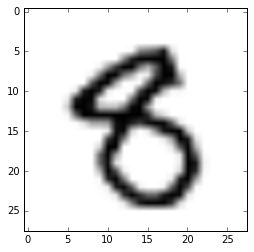

In [3]:
img = X_train[np.random.randint(len(X_train))]
plt.imshow(np.squeeze(img), cmap='Greys') # the squeeze is needed to remove the channel dimensions

Recall that we can create a function to extract hidden layer data:

In [4]:
from keras import backend as K

get_layer1 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[1].output])

H = get_layer1([img[np.newaxis], 0])[0]

The function `get_layer1` will take an input image and return the feature maps for all filters in the first convolutional layer. When we use it, we need to make sure that all of the dimensions match. The model input has the shape `[batch, channels, width, height]`. We will be feeding one image at a time and we need to make the shape match the expected input. Note that we feed in a list of values: the first value is the input data and the second is a flag to tell Keras that we are not using the network in learning mode. This is important if the model as any dropout layers or other layers whose behavior is different during learning.

In [5]:
print img.shape
print img[np.newaxis].shape # This adds the batch dimension (size of 1 for 1 image)

(1, 28, 28)
(1, 1, 28, 28)


Let's feed in an image and check the output shape.

In [6]:
H = get_layer1([img[np.newaxis], 0])[0]
print H.shape

(1, 32, 26, 26)


- - -
### Exercise 1 - Layer shapes

Based on your model and the size of the convolutional layers, explain why the output shape has the size it does. Check you explanation with the instructor or a classmate.
- - -

We can display the feature maps as images. For example, the line below will show the 10th feature map from the extracted features of the image we chose. Lighter areas correspond to areas where the feature is more "on" - i.e. where the corresponding filter matches the input image

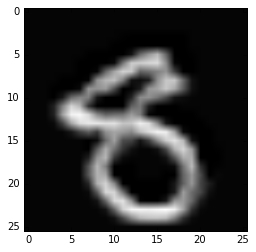

In [7]:
plt.imshow(H[0, 10], cmap='Greys_r')

You can take a look at other filters by changing the `10` above. But let's make things easier and build a function to display _all_ the filters in one go.

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_all_feature_maps(H):
    # make a square grid
    num_maps = H.shape[1]
    rows = int(np.ceil(np.sqrt(float(num_maps))))

    fig = plt.figure(1, [10, 10])
    grid = ImageGrid(fig, 111, nrows_ncols=[rows, rows])

    for i in range(num_maps):
        grid[i].axis('off')
        grid[i].imshow(H[0, i], cmap='Greys_r')
        
    # Turn any unused axes off
    for j in range(i, len(grid)):
        grid[j].axis('off')

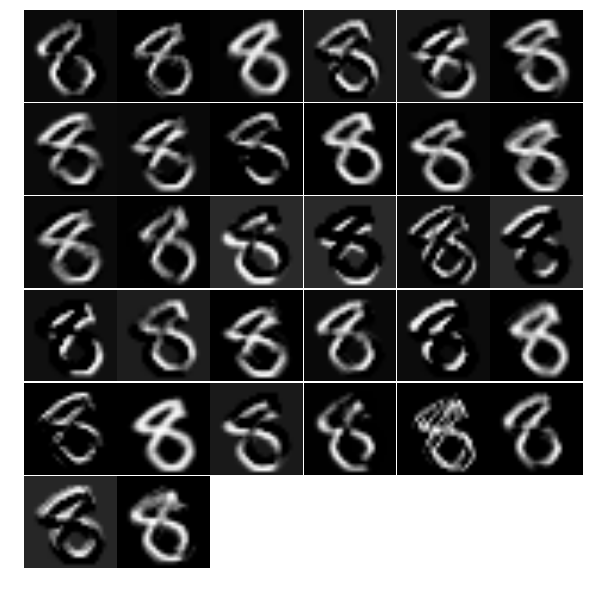

In [9]:
show_all_feature_maps(H)

- - -
### Exercise 2 - Characterizing filters

Using the handy visualization tool we just build, let's inspect what our model learned. Feed some examples in and visualize the feature maps.

1. Can you find features that look like edge detectors?
2. Try to find a filter that likes edges with a dark part on the left and a light part on the right.
3. Try to find filters that like edges in different orientations.
4. Can you find a filter that likes more than one edge orientation?

Record which filters you find for the above questions and any others you find interesting.
- - -

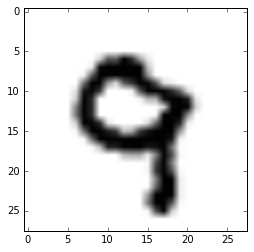

In [10]:
img = X_train[np.random.randint(len(X_train))]
plt.imshow(np.squeeze(img), cmap='Greys')

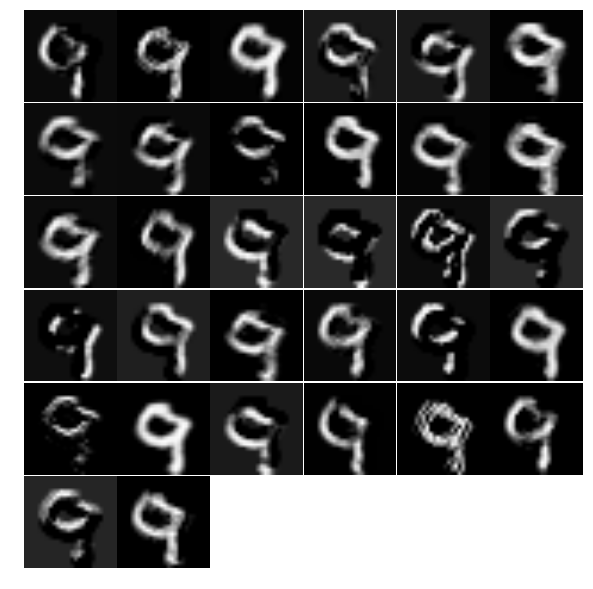

In [11]:
show_all_feature_maps(get_layer1([img[np.newaxis]])[0])

- - -
### Exercise 3 - visualizing the next conv layer

Let's take a look a the next conv layer feature maps.

1. Define a `get_layer2` function like `get_layer1` above that will extract the next convolutional layer output. It can be useful to print out `model.layers` to see what the index of the layer you want is.
2. Are the feature maps more complex than the previous layer? If you think so, characterize how as best you can. Talk this over.
3. Can you find filters that seem to "like" a particular number better than others? In what sense is this the case?
- - -

In [12]:
# Analyze the next conv layer by visualizing its feature maps
get_layer2 = K.function([model.layers[0].input], [model.layers[3].output])

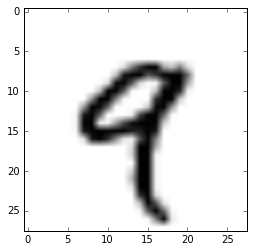

In [13]:
img = X_train[4] # Choosing the 5th training example
plt.imshow(np.squeeze(img), cmap='Greys')

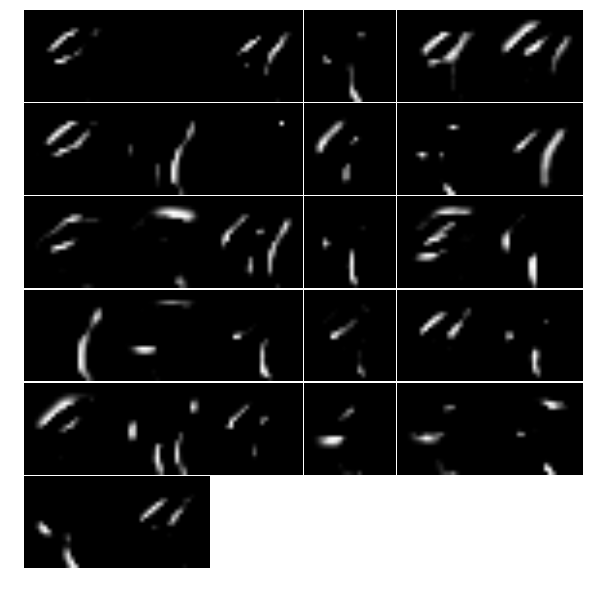

In [14]:
show_all_feature_maps(get_layer2([img[np.newaxis]])[0])

## Visualizing filters

Another way to understand what a network has learned is to visualize it's filters. For the filters in the first layer, this can be done easily because those filters are in the space of the input image. This means we can display them as an image to get an idea of what they are trying to match. We can extract the weights from the layers in out model as below.

In [15]:
print 'Conv weights:', model.layers[0].get_weights()[0].shape
print 'Biases:', model.layers[0].get_weights()[1].shape

Conv weights: (32, 1, 3, 3)
Biases: (32,)


Let's plot some of the filters randomly by running the code below a few times.

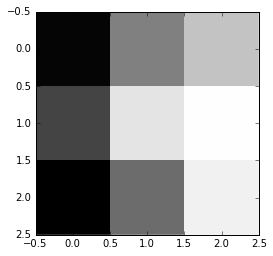

In [16]:
W = model.layers[0].get_weights()[0] # get the conv weights as W
F = np.squeeze(W)[np.random.randint(len(W))] # just choose a random weight

plt.imshow(F, cmap='Greys_r', interpolation='none')

- - -
### Exercise 4 - Edge detector filters

In the feature maps we already saw you might have spotted filters that seem to "like" edges. Plot some of the filters below and compare them to the corresponding feature map. Explain with some examples that you find how these edge detectors work. 

Remember: light corresponds you large weights and dark corresponds to low weights. It is a good idea to print out the filters weight themselves with `print F` to make sure this checks out.
- - -

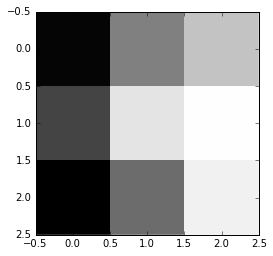

In [17]:
# Find and plot edge detector filters
F = np.squeeze(W)[0]
plt.imshow(F, cmap='Greys_r', interpolation='none')